In [1]:
#from typing import Match

import numpy as np
import matplotlib
import matplotlib.pyplot as plt # para plots
import itertools


### Gerando nosso Dataset ###

In [47]:

# Função que define a equação diferencial
def EDO_pendulo(t, y):
    theta, d_theta_dt = y
    dd_theta_dt = - (g / L) * np.sin(theta)
    return [d_theta_dt, dd_theta_dt]

def generate_data_set(omega = 1, theta = 0, time_parameters =[] ):
    t_0,t_end,dt = time_parameters    
    # Método de Euler para resolver a EDO
    t_values = np.arange(t_0, t_end, dt)

    theta_values = []
    omega_values = []
    for t in t_values:
        theta_values.append(theta)
        omega_values.append(omega)
        
        # Método de Euler
        dtheta_dt, domega_dt = EDO_pendulo(t, [theta, omega])
        theta += dtheta_dt * dt
        omega += domega_dt * dt

    # Converter o deslocamento angular para coordenadas x-y
    x_values = L * np.sin(theta_values)
    y_values = -L * np.cos(theta_values)
    return [x_values,y_values]

def plot_Pendulum(data):
    x_values, y_values = data 
    # Plotagem
    plt.plot(x_values, y_values)
    plt.xlabel('x (t)')
    plt.ylabel('y (t)')
    plt.title('Movimento do Pêndulo Simples')
    plt.grid(True)
    plt.axis('equal')
    plt.show()



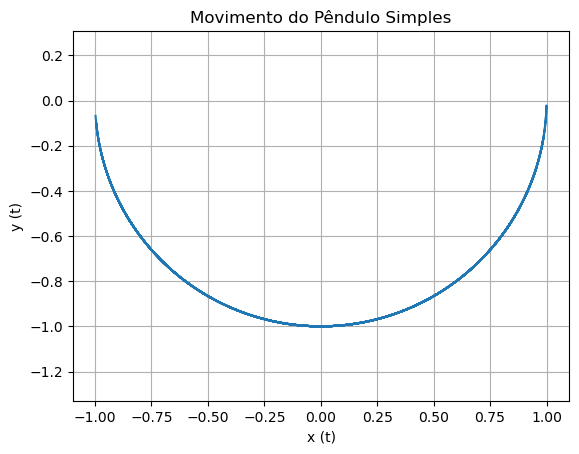

In [48]:

# Constantes
global g, L, phi, omega_0
g = 9.81  # m/s^2, aceleração devido à gravidade
L = 1.0   # m, comprimento do pêndulo
phi = np.pi / 3  # Ângulo inicial em radianos
omega_0 = 0.0        # Velocidade angular inicial

# Parâmetros de tempo
N=1000 # Numero de pontos
t_0 = 0.0            # Tempo inicial
t_end = 10.0         # Tempo final
dt = t_end/N            # Tamanho do passo de tempo
time_parameters = [t_0,t_end,dt]

# Condições iniciais
theta = phi 
omega = omega_0

data = generate_data_set(omega, theta, time_parameters)
plot_Pendulum(data)


### Usando o perceptron para adquirir informação sobre o sistema 


Suponha agora que só há o data set como entrada, ou seja, não temmos mais informação do que a imagem plotada acima. Vamos usar o perceptron para verificar se conseguimos adquirir informação sobre a fase e frequencia do nosso pendulo apenas alimentando a rede com (x,y).

In [49]:

# definindo funções do perceptron

def perceptron(y_in = [], w=[], b=[]) :
    z_in = np.dot(y_in,w) + b
    z_out = activation(z_in)
    return z_out

def activation(z=0):
    return np.sin(z)

def sigmoid (z=0):
    return 1/(1 + np.exp(-z))

def create_Randomweights_perceptron(Ns =[]):
    ''' cria pesos e bias aleatorios para o perceptron.
    '''
    w = np.random.uniform(low=-10,high=10,size=(2,1))
    b = np.random.uniform(low=-np.pi,high=np.pi,size=(1))
    return [w,b]


